#Melanoma Detection Assignment

> Author: Sudarshan `(sudarshan_g@outlook.com)` <br>
> Date: 4th December 2023

## Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis. <br>

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant. <br>

The data set contains the following diseases:
- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

## Library Imports

In [1]:
import os, pathlib

import numpy as np
import matplotlib.pyplot as plt

!pip install Augmentor > /dev/null
import Augmentor
import PIL

## TensorFlow
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential

## For connecting & downloading the dataset/running on colab.
!pip install gdown > /dev/null
from google.colab import drive
import gdown

In [2]:
# ## For Google drive
# drive.mount('/content/gdrive', force_remount=True)

# # get the path containing unzipped training and testing melanoma datasets
# melanoma_train_dir = pathlib.Path("/content/gdrive/MyDrive/AIML/MelanomaDataset/Train")
# melanoma_test_dir = pathlib.Path('/content/gdrive/MyDrive/AIML/MelanomaDataset/Test')

In [3]:
# # Clear already unzipped directory
# import shutil
# shutil.rmtree("/content/Melanoma_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/")

In [4]:
# For Local CUDA runtime
!unzip "/content/Melanoma_Dataset/CNN_assignment.zip" -d "/content/Melanoma_Dataset/"  > /dev/null

# get the local container path with unzipped train and test data.
melanoma_train_dir = pathlib.Path("/content/Melanoma_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
melanoma_test_dir = pathlib.Path('/content/Melanoma_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [5]:
# Print the image counts
print("Training image count:", len(list(melanoma_train_dir.glob('*/*.jpg'))))
print("Testing image count:", len(list(melanoma_test_dir.glob('*/*.jpg'))))

Training image count: 2239
Testing image count: 118


## Load using keras.preprocessing

In [6]:
## Parameters related to batch size and image dimensions.
batch_size = 32
img_height = 180
img_width = 180

In [7]:
## Training & Validation imports

melanoma_train = tf.keras.preprocessing.image_dataset_from_directory(
    directory=melanoma_train_dir, label_mode='categorical', labels='inferred',
    subset= 'training', validation_split= 0.2, image_size=(img_height, img_width),
    batch_size = batch_size, shuffle=True, seed=123)

melanoma_validation = tf.keras.preprocessing.image_dataset_from_directory(
    directory=melanoma_train_dir, label_mode='categorical', labels = 'inferred',
    subset= 'validation', validation_split= 0.2, image_size=(img_height,img_width),
    batch_size = batch_size, shuffle=True, seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
class_names = melanoma_train.class_names
print("Class names:", class_names)
print("Count: ", len(class_names))

Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Count:  9


## Visualizing the dataset

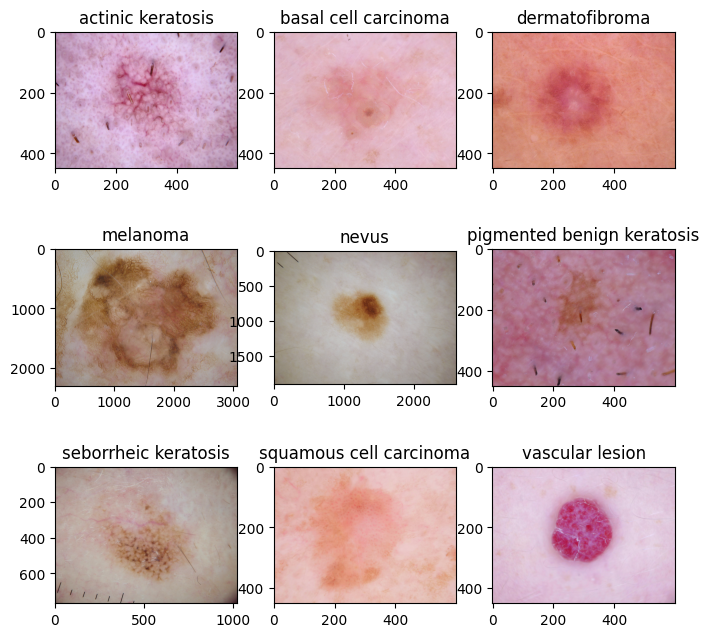

In [9]:
plt.figure(figsize=(8,8))

for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(melanoma_train_dir.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

Each batch is a tensor of shape (32, 180, 180, 3) - 32 images each 180x180 in RGB.
We will cache this in memory afer first load. Prefetch is going to read ahead the images using a background thread before they are requested. The number of items to prefetch is automatically determined at runtime using the `AUTOTUNE`. parameter

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
melanoma_train = melanoma_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
melanoma_validation = melanoma_validation.cache().prefetch(buffer_size=AUTOTUNE)

## Initial Model Creation (model_v1)

In [11]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation
num_classes = len(class_names)

In [12]:
# Initial simple CNN
model_v1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180,3)),

  Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'),
  Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu'),
  MaxPool2D(pool_size=(2,2)),

  Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'),
  MaxPool2D(pool_size=(2,2)),

  Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'),
  MaxPool2D(pool_size=(2,2)),

  Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'),
  MaxPool2D(pool_size=(2,2)),

  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='softmax')
])


In [13]:
# Compile
model_v1.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
# Summary
model_v1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      6416      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Initial model training & results

In [14]:
epochs = 20
results = model_v1.fit(melanoma_train, validation_data=melanoma_validation, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 12s 63ms/step - loss: 2.0605 - accuracy: 0.1964 - val_loss: 2.0219 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 2s 40ms/step - loss: 1.9563 - accuracy: 0.2416 - val_loss: 1.8542 - val_accuracy: 0.2953
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.7408 - accuracy: 0.3644 - val_loss: 1.7255 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5573 - accuracy: 0.4520 - val_loss: 1.4910 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5193 - accuracy: 0.4710 - val_loss: 1.4561 - val_accuracy: 0.4922
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4419 - accuracy: 0.4877 - val_loss: 1.4656 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3605 - accuracy: 0.5206 - val_loss: 1.5546 - val_accuracy: 0.4765
Epoch 8/20
5

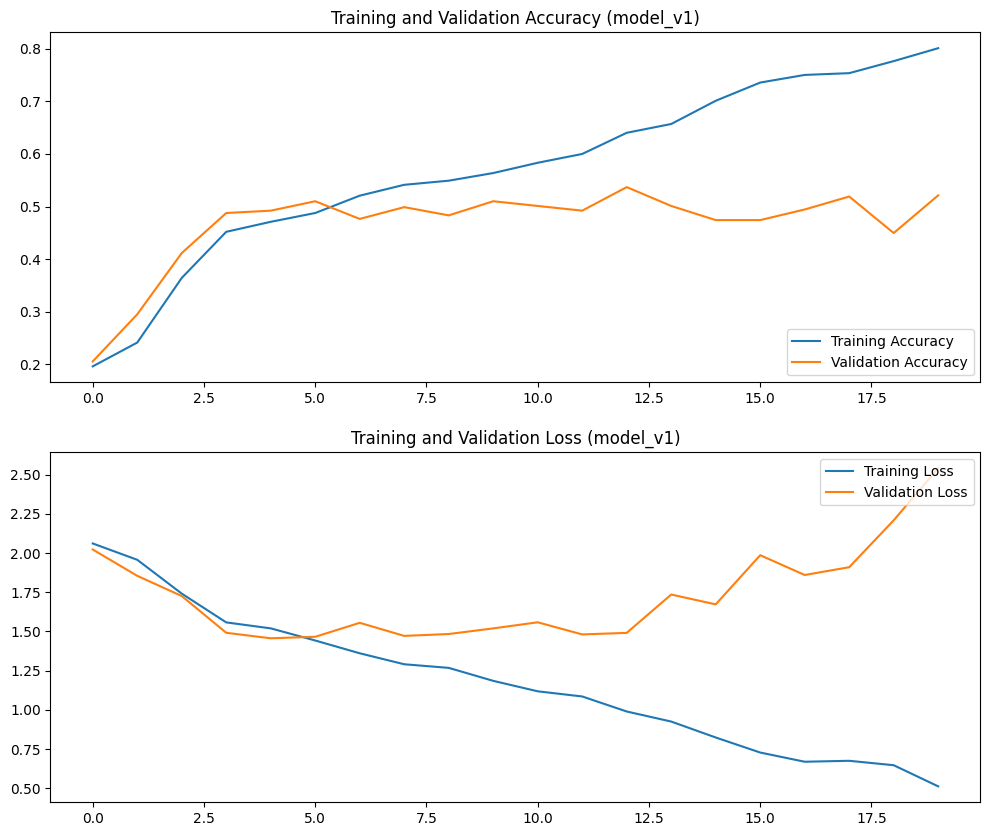

In [15]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (model_v1)')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (model_v1)')
plt.show()

Findings + Next Steps:
- After ~13th epoch, validation loss keeps increasing while training loss continues declining, because of this we see no improvements in validation accuracy.
- Seems like a overfit situation. Let's address it by adding some additional layers and drop outs. We will also check for any class imbalance before building the next model.

## 2nd Model Creation (model_v2)

### Class imbalance check & treatment

In [16]:
# Sample count against each class
for i in class_names:
    directory =melanoma_train_dir.as_posix()+'/'+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'Class: {i} => {length} images.')

Class: actinic keratosis => 114 images.
Class: basal cell carcinoma => 376 images.
Class: dermatofibroma => 95 images.
Class: melanoma => 438 images.
Class: nevus => 357 images.
Class: pigmented benign keratosis => 462 images.
Class: seborrheic keratosis => 77 images.
Class: squamous cell carcinoma => 181 images.
Class: vascular lesion => 139 images.


- Lowest: `seborrheic keratosis` at 77 samples.
- Highest: `pigmented benign keratosis` at 462 samples.

In [17]:
## Utilzing Augmentor to fix this. Already imported at the 1st cell.
for i in class_names:
    p = Augmentor.Pipeline(melanoma_train_dir.as_posix()+'/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) # higher the no. of samples, more balanced our dataset will be


Initialised with 114 image(s) found.
Output directory set to /content/Melanoma_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEE51B49570>: 100%|██████████| 500/500 [00:02<00:00, 170.27 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Melanoma_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEE63F77C10>: 100%|██████████| 500/500 [00:02<00:00, 167.04 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Melanoma_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEE3C52A9E0>: 100%|██████████| 500/500 [00:02<00:00, 167.31 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Melanoma_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FEE3C439FC0>: 100%|██████████| 500/500 [00:11<00:00, 44.23 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Melanoma_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEE63F77A30>: 100%|██████████| 500/500 [00:10<00:00, 49.91 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Melanoma_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEE3C5691E0>: 100%|██████████| 500/500 [00:03<00:00, 164.00 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Melanoma_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FEE63F01A20>: 100%|██████████| 500/500 [00:05<00:00, 89.94 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to /content/Melanoma_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEE3C45CF10>: 100%|██████████| 500/500 [00:02<00:00, 172.79 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Melanoma_Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEE63F00DF0>: 100%|██████████| 500/500 [00:02<00:00, 172.94 Samples/s]


In [18]:
# 500 augmented images for each of the 9 classes
image_count_train = len(list(melanoma_train_dir.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [19]:
import glob
path_list = [x for x in glob.glob(os.path.join(melanoma_train_dir.as_posix(), '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(melanoma_train_dir.as_posix(), '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

# counting the total number of images including the augmented images
for i in class_names:
    directory=melanoma_train_dir.as_posix()+'/'+i+'/'
    aug_output=melanoma_train_dir.as_posix()+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_aug_output = pathlib.Path(aug_output)
    length=len(list(class_directory.glob('*.jpg')))
    length_aug=len(list(class_aug_output.glob('*.jpg')))
    length_tot=length+length_aug
    print(f'Class: {i} => {length_tot} images. [Augmented by {length_aug}]')

Class: actinic keratosis => 614 images. [Augmented by 500]
Class: basal cell carcinoma => 876 images. [Augmented by 500]
Class: dermatofibroma => 595 images. [Augmented by 500]
Class: melanoma => 938 images. [Augmented by 500]
Class: nevus => 857 images. [Augmented by 500]
Class: pigmented benign keratosis => 962 images. [Augmented by 500]
Class: seborrheic keratosis => 577 images. [Augmented by 500]
Class: squamous cell carcinoma => 681 images. [Augmented by 500]
Class: vascular lesion => 639 images. [Augmented by 500]


### Creating a new dataset after Augmentation

In [20]:
## Training & Validation imports

melanoma_train = tf.keras.preprocessing.image_dataset_from_directory(
    directory=melanoma_train_dir, label_mode='categorical', labels='inferred',
    subset= 'training', validation_split= 0.2, image_size=(img_height, img_width),
    batch_size = batch_size, shuffle=True, seed=123)

melanoma_validation = tf.keras.preprocessing.image_dataset_from_directory(
    directory=melanoma_train_dir, label_mode='categorical', labels = 'inferred',
    subset= 'validation', validation_split= 0.2, image_size=(img_height,img_width),
    batch_size = batch_size, shuffle=True, seed=123)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Building the 2nd model

In [21]:
## Modifications from model_v1
## Adds another CNN layer of 128 and dense layer of 256.
## We also add dropouts at certain places.

model_v2 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180,3)),

  Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'),
  Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu'),
  MaxPool2D(pool_size=(2,2)),
  Dropout(0.1),

  Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'),
  MaxPool2D(pool_size=(2,2)),
  Dropout(0.1),

  Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'),
  MaxPool2D(pool_size=(2,2)),
  Dropout(0.1),

  Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same', activation ='relu'),
  MaxPool2D(pool_size=(2,2)),
  Dropout(0.1),

  Flatten(),

  Dense(256, activation='relu'),
  Dropout(0.2),

  Dense(128, activation='relu'),
  Dropout(0.1),
  Dense(num_classes, activation='softmax')
])

# Compile, using Adam optimizer
model_v2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
# Summary
model_v2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      6416      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

In [22]:
epochs = 30
results = model_v2.fit(melanoma_train, validation_data=melanoma_validation, epochs=epochs)

Epoch 1/30
169/169 [==============================] - 15s 71ms/step - loss: 1.9697 - accuracy: 0.2263 - val_loss: 1.7415 - val_accuracy: 0.3073
Epoch 2/30
169/169 [==============================] - 10s 60ms/step - loss: 1.7639 - accuracy: 0.3066 - val_loss: 1.6773 - val_accuracy: 0.3281
Epoch 3/30
169/169 [==============================] - 10s 60ms/step - loss: 1.6784 - accuracy: 0.3461 - val_loss: 1.5955 - val_accuracy: 0.3712
Epoch 4/30
169/169 [==============================] - 10s 60ms/step - loss: 1.6229 - accuracy: 0.3769 - val_loss: 1.4782 - val_accuracy: 0.4172
Epoch 5/30
169/169 [==============================] - 10s 60ms/step - loss: 1.4942 - accuracy: 0.4188 - val_loss: 1.6106 - val_accuracy: 0.4031
Epoch 6/30
169/169 [==============================] - 10s 61ms/step - loss: 1.4134 - accuracy: 0.4440 - val_loss: 1.3423 - val_accuracy: 0.4699
Epoch 7/30
169/169 [==============================] - 10s 60ms/step - loss: 1.3513 - accuracy: 0.4662 - val_loss: 1.2771 - val_accuracy:

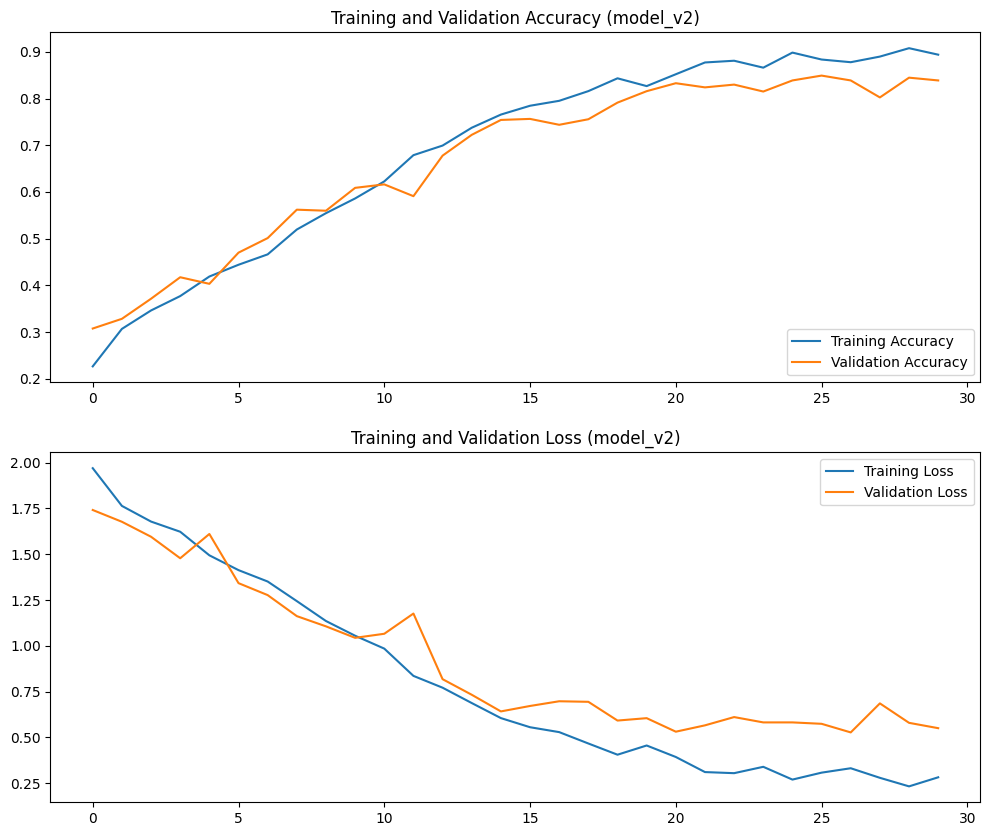

In [23]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (model_v2)')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (model_v2)')
plt.show()

In [24]:
# Google Drive
# model_v1.save('/content/gdrive/MyDrive/AIML/model_v1.keras')
# model_v2.save('/content/gdrive/MyDrive/AIML/model_v2.keras')

# Local
model_v1.save('/content/Melanoma_Dataset/model_v1.keras')
model_v2.save('/content/Melanoma_Dataset/model_v2.keras')

Findings:
- `model_v2` performs reasonably well on both training and validation datasets with accuracies of `0.8941` and `0.8389` respectively after training for `30` epochs.
- `model_v2` after 30 epochs has the training loss at `0.2828` and the validation loss at `0.5509`.


## 3rd Model Creation (model_v3)


### Adding Batch Normalization and additional layer to existing model.

Changes -
- `BatchNormalization()` added after few Conv2D layers.
- `Activation('relu')` moved after batch normalization for each layer
- Adds a Conv2D layer with 256 filters and (11,11) kernel size with `relu` activation.

In [87]:
model_v3 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180,3)),

  Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation='relu'),
  Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation='relu'),
  MaxPool2D(pool_size=(2,2)),
  Dropout(0.1),

  Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same'),
  BatchNormalization(),
  Activation('relu'),

  MaxPool2D(pool_size=(2,2)),
  Dropout(0.1),

  Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same'),
  BatchNormalization(),
  Activation('relu'),

  MaxPool2D(pool_size=(2,2)),
  Dropout(0.1),

  Conv2D(filters = 128, kernel_size = (5,5), padding = 'Same', activation='relu'),
  Conv2D(filters = 256, kernel_size = (11,11), padding='Same', activation='relu'),
  MaxPool2D(pool_size=(2,2)),
  Dropout(0.2),

  MaxPool2D(pool_size=(2,2)),
  Dropout(0.1),

  Flatten(),
  Dense(256),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.2),

  Dense(128),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),

  Dense(num_classes, activation='softmax')
])

# Compile, using AdamW (Adam with weight decay) optimizer
model_v3.compile(optimizer=keras.optimizers.AdamW(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
# Summary
model_v3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 conv2d_49 (Conv2D)          (None, 180, 180, 16)      6416      
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_51 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_50 (Conv2D)          (None, 90, 90, 32)        4640      
                                                      

In [88]:
epochs = 30
results = model_v3.fit(melanoma_train, validation_data=melanoma_validation, epochs=epochs)

Epoch 1/30
169/169 [==============================] - 20s 84ms/step - loss: 1.9177 - accuracy: 0.2834 - val_loss: 2.3151 - val_accuracy: 0.1470
Epoch 2/30
169/169 [==============================] - 14s 80ms/step - loss: 1.5886 - accuracy: 0.4019 - val_loss: 2.0009 - val_accuracy: 0.2665
Epoch 3/30
169/169 [==============================] - 14s 80ms/step - loss: 1.4549 - accuracy: 0.4462 - val_loss: 2.2855 - val_accuracy: 0.2435
Epoch 4/30
169/169 [==============================] - 14s 80ms/step - loss: 1.3246 - accuracy: 0.4898 - val_loss: 1.9389 - val_accuracy: 0.3103
Epoch 5/30
169/169 [==============================] - 14s 80ms/step - loss: 1.2424 - accuracy: 0.5252 - val_loss: 1.5288 - val_accuracy: 0.4165
Epoch 6/30
169/169 [==============================] - 14s 81ms/step - loss: 1.1210 - accuracy: 0.5801 - val_loss: 1.6281 - val_accuracy: 0.4454
Epoch 7/30
169/169 [==============================] - 14s 81ms/step - loss: 0.9900 - accuracy: 0.6257 - val_loss: 1.6073 - val_accuracy:

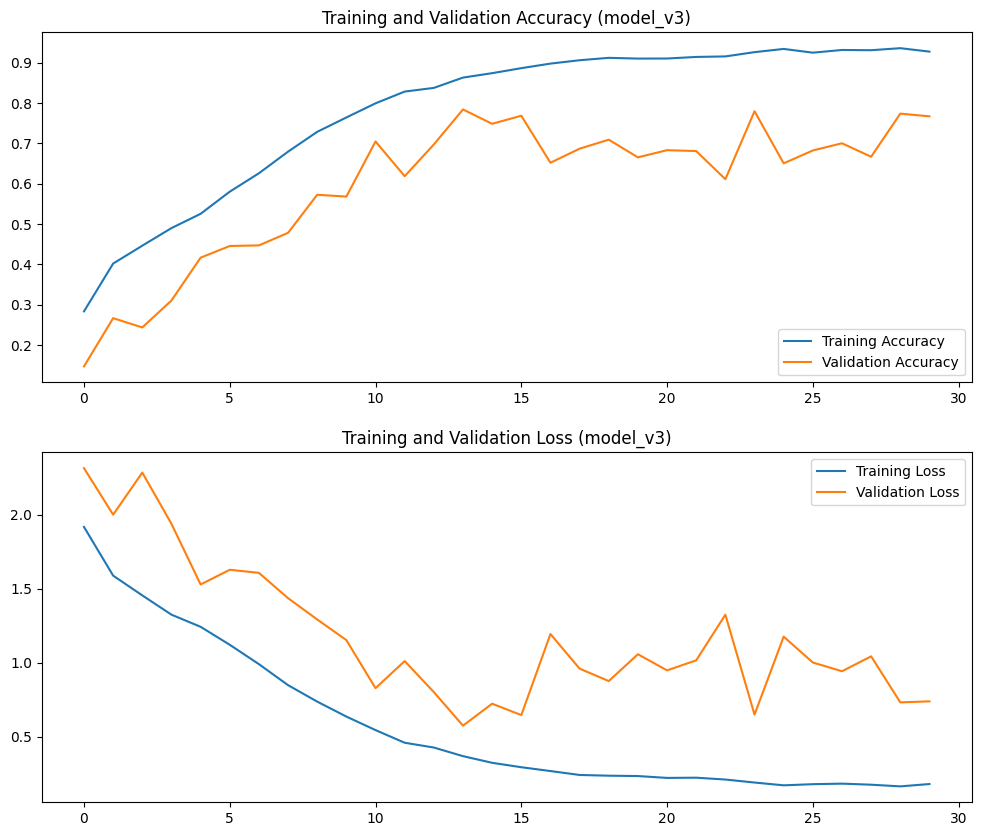

In [89]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (model_v3)')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (model_v3)')
plt.show()

In [28]:
#Local
model_v3.save('/content/Melanoma_Dataset/model_v3.keras')

## Findings

After 30 epochs on `model_v3`:
- Stats: training loss: 0.1616, training accuracy: 0.9347 - validation loss: 0.8206, validation accuracy: 0.7379

- We have removed the underfitting problem and have also resolved class imbalance issues using the `Augmentor`

- We do see massive spikes in validation loss due to the much smaller sample size compared to training.

- This model converges much faster than model_v2. We do see that at certain earlier epochs we have better validation accuracies for a minor dip in training accuracies. For e.g. <br>

```
Epoch 23/30
169/169 [==============================] - 16s 96ms/step - loss: 0.2001 - accuracy: 0.9175 - val_loss: 0.4160 - val_accuracy: 0.8649
```

and

```
Epoch 26/30
169/169 [==============================] - 16s 95ms/step - loss: 0.1887 - accuracy: 0.9290 - val_loss: 0.3892 - val_accuracy: 0.8627
```

## Checkpointing model_v3
Since we noticed during the previous fit that we have better metrics in some of the earlier epochs, let's save them and load it later.

In [93]:
# ref: Known issue: not able to save as .keras - https://stackoverflow.com/questions/76701617/the-following-arguments-are-not-supported-with-the-native-keras-format-opti
checkpoint = keras.callbacks.ModelCheckpoint(filepath="/content/Melanoma_Dataset/model_v3c_best.tf", monitor="val_accuracy", verbose=1, save_best_only=True)

In [94]:
model_v3c = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180,3)),

  Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation='relu'),
  Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation='relu'),
  MaxPool2D(pool_size=(2,2)),
  Dropout(0.1),

  Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same'),
  BatchNormalization(),
  Activation('relu'),

  MaxPool2D(pool_size=(2,2)),
  Dropout(0.1),

  Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same'),
  BatchNormalization(),
  Activation('relu'),

  MaxPool2D(pool_size=(2,2)),
  Dropout(0.1),

  Conv2D(filters = 128, kernel_size = (5,5), padding = 'Same', activation='relu'),
  Conv2D(filters = 256, kernel_size = (11,11), padding='Same', activation='relu'),
  MaxPool2D(pool_size=(2,2)),
  Dropout(0.2),

  MaxPool2D(pool_size=(2,2)),
  Dropout(0.1),

  Flatten(),
  Dense(256),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.2),

  Dense(128),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),

  Dense(num_classes, activation='softmax')
])

# Compile, using AdamW (Adam with weight decay) optimizer
model_v3c.compile(optimizer=keras.optimizers.AdamW(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
# Summary
model_v3c.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 conv2d_61 (Conv2D)          (None, 180, 180, 16)      6416      
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_65 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_62 (Conv2D)          (None, 90, 90, 32)        4640      
                                                     

In [95]:
epochs=30
results = model_v3c.fit(melanoma_train, validation_data=melanoma_validation, epochs=epochs, callbacks=[checkpoint])

Epoch 1/30
168/169 [============================>.] - ETA: 0s - loss: 1.7949 - accuracy: 0.3268
Epoch 1: val_accuracy improved from -inf to 0.14031, saving model to /content/Melanoma_Dataset/model_v3c_best.tf
169/169 [==============================] - 23s 102ms/step - loss: 1.7955 - accuracy: 0.3266 - val_loss: 2.7537 - val_accuracy: 0.1403
Epoch 2/30
168/169 [============================>.] - ETA: 0s - loss: 1.5251 - accuracy: 0.4169
Epoch 2: val_accuracy improved from 0.14031 to 0.19154, saving model to /content/Melanoma_Dataset/model_v3c_best.tf
169/169 [==============================] - 17s 100ms/step - loss: 1.5252 - accuracy: 0.4167 - val_loss: 2.2573 - val_accuracy: 0.1915
Epoch 3/30
168/169 [============================>.] - ETA: 0s - loss: 1.3908 - accuracy: 0.4606
Epoch 3: val_accuracy improved from 0.19154 to 0.29324, saving model to /content/Melanoma_Dataset/model_v3c_best.tf
169/169 [==============================] - 17s 98ms/step - loss: 1.3914 - accuracy: 0.4607 - val_lo

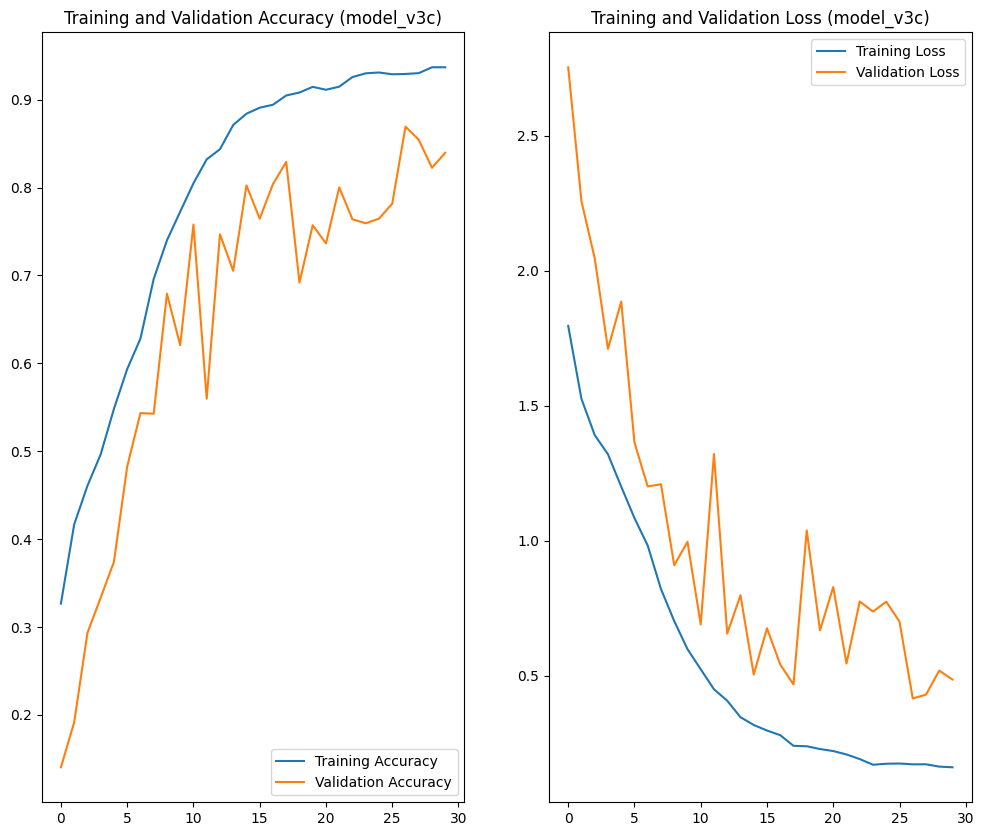

In [96]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

epochs_range = range(len(results.epoch))

plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (model_v3c)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (model_v3c)')
plt.show()

We trained for 30 epochs and picked the best model from it.
The best model is from epoch 27 with highest validation accuracy -

```
Epoch 27/30
168/169 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9293
Epoch 27: val_accuracy improved from 0.82925 to 0.86934, saving model to /content/Melanoma_Dataset/model_v3c_best.tf
169/169 [==============================] - 18s 105ms/step - loss: 0.1717 - accuracy: 0.9293 - val_loss: 0.4156 - val_accuracy: 0.8693
```

We see that the overfit issue is gone compared to earlier models.

## Plotting our final model architecture

In [97]:
model_v3c = tf.keras.saving.load_model(
    "/content/Melanoma_Dataset/model_v3c_best.tf/", custom_objects=None, compile=True
)

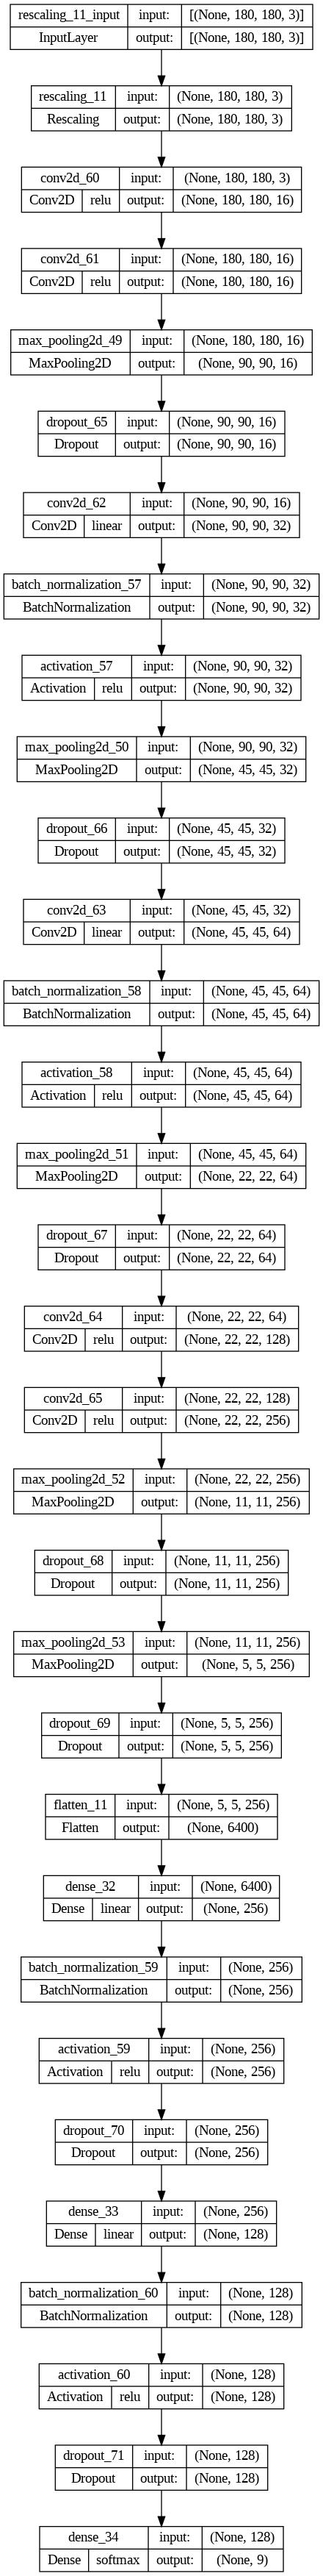

In [98]:
from keras.utils import plot_model
plot_model(model_v3c,'model_v3c_architecture.jpg',show_layer_names=True,show_shapes=True,show_layer_activations=True)

## Prediction on the holdout set.
We have `melanoma_test_dir` as our holdout set which contains unseen images.
Let's see how our model performs on a sample image for each class

In [99]:
from glob import glob
from keras.preprocessing.image import load_img, img_to_array

for x in range(9):
  Test_image_path = os.path.join(melanoma_test_dir.as_posix(), class_names[x], '*')
  Test_image = glob(Test_image_path)
  Test_image = load_img(Test_image[-1],target_size=(180,180,3))
  #plt.imshow(Test_image)
  #plt.grid(False)

  img = np.expand_dims(Test_image,axis=0)
  pred = model_v3.predict(img,verbose=0)
  pred = np.argmax(pred)
  pred_class = class_names[pred]
  if pred_class == class_names[x]:
    print(f"✔ Actual Class: {class_names[x]}" + " | " + "Predicted Class: " + pred_class)
  else:
    print(f"X Actual Class: {class_names[x]}" + " | " + "Predicted Class: " + pred_class)

✔ Actual Class: actinic keratosis | Predicted Class: actinic keratosis
✔ Actual Class: basal cell carcinoma | Predicted Class: basal cell carcinoma
X Actual Class: dermatofibroma | Predicted Class: pigmented benign keratosis
✔ Actual Class: melanoma | Predicted Class: melanoma
X Actual Class: nevus | Predicted Class: pigmented benign keratosis
✔ Actual Class: pigmented benign keratosis | Predicted Class: pigmented benign keratosis
X Actual Class: seborrheic keratosis | Predicted Class: melanoma
✔ Actual Class: squamous cell carcinoma | Predicted Class: squamous cell carcinoma
✔ Actual Class: vascular lesion | Predicted Class: vascular lesion


We see that model_v3c is correctly predicting 6/9 classes on the unseen dataset when a random image is picked.

-- END --